In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

# Contact between Sphere and Plane
[https://en.wikipedia.org/wiki/Contact_mechanics]

<div>
<img src=img/Contact_sphere-plane.jpg" width="400"/>
</div>

Pressure distribution: 
$$p(r) = p_0\left(1 - \frac{r^2}{a^2}\right)^\frac{1}{2}$$

Max pressure: 
$$ p_0 = \frac{3F}{2\pi a^2}$$

To compute the displacement and therefore the effective radius $a$ the link suggests to use:
$$F = \frac{4}{3} E^*R^\frac{1}{2}d^\frac{3}{2}$$

where
$$\frac{1}{E^*} = \frac{1 - \nu^2_1}{E_1} + \frac{1 - \nu^2_2}{E_2}$$

But the simulator we use only allows setting a stiffness $k$. Therfore I compute the displacement as:
$$d = F / k$$

# Torsinal Friction

To compute the maximal torque that such a contact can withstand, we 
 - sample points the in the unit circle (or rather their distance to the origin) 
 - compute the effective pressure at that distance
 - integrate (avergage) pressure times distance over the area


In [2]:
# https://en.wikipedia.org/wiki/Contact_mechanics
# https://physics.stackexchange.com/questions/289543/pressure-of-a-sphere-against-the-ground

def get_effective_radius(
        radius: float, 
        external_force: float,
        params: Union[Tuple[float, float, float, float], float]
    ):  
    if isinstance(params, tuple):
        # Herztian Stress
        ν_sphere, ν_plane, E_sphere, E_plane = params
        effective_radius = (
            0.75
            * external_force
            * radius
            * (1 - ν_sphere**2 / E_sphere + ν_plane**2 / E_plane)
        ) ** (1/3)
    else:
        # Stiffness
        stiffness = params
        penetration = external_force / stiffness
        effective_radius = np.sqrt(radius**2 - (radius - penetration) ** 2)

        # TODO: Show E_star for both cases
        # E_star = 0.75 * external_force * radius ** 0.5 * penetration ** 1.5

    return effective_radius

def get_torque(effective_radius: float, external_force: float, friction: float = 0.8):

    area = np.pi * effective_radius**2
    max_pressure = 3 * external_force / (2 * np.pi * effective_radius**2)

    # Sample points on circle
    num_samples = 10000
    length = np.sqrt(np.random.uniform(0, 1, num_samples)) * effective_radius
    
    effective_pressure = max_pressure * (1 - (length**2 / effective_radius**2)) ** 0.5

    total_force = np.mean(effective_pressure) * area   
    assert (total_force - external_force) / external_force < 0.05 
    
    torque = np.mean(length * effective_pressure * friction) * area
    return torque

<IPython.core.display.Javascript object>


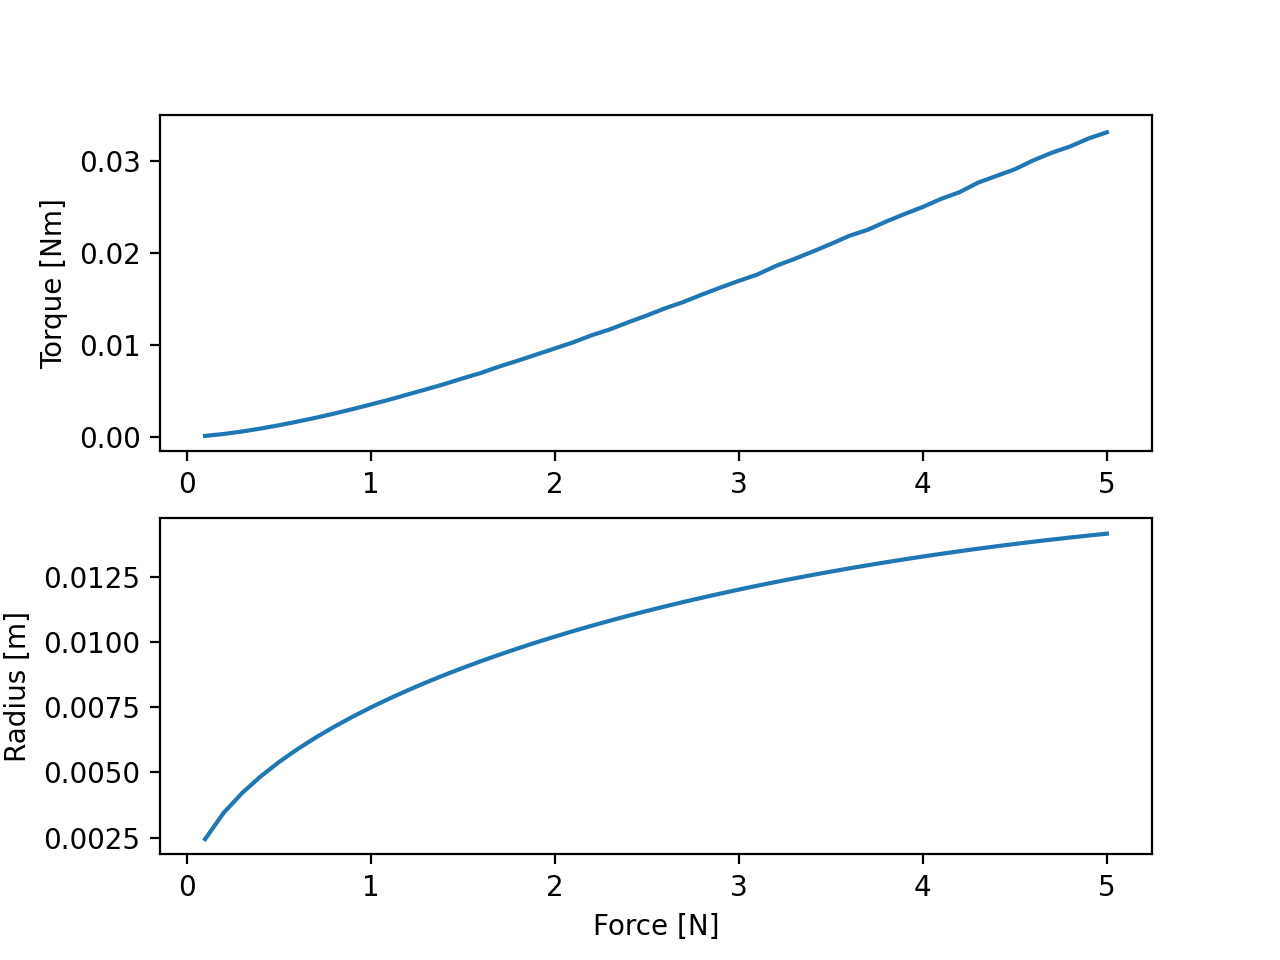

interactive(children=(FloatSlider(value=0.015, description='radius', max=1.0, min=0.01, step=0.01), IntSlider(…

In [3]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

radius = 0.015 # m
stiffness = 500.0 # N/m

forces = np.linspace(0.1, 5, 50) # N
fig = plt.figure()
ax_torque = fig.add_subplot(2, 1, 1)
ax_radius = fig.add_subplot(2, 1, 2)

def get_lists(radius, forces, stiffness):
    torques = []
    radiuses = []
    for external_force in forces:
        effective_radius = get_effective_radius(radius, external_force, stiffness)
        torques.append(get_torque(effective_radius, external_force))
        radiuses.append(effective_radius)
    return torques, radiuses

torques, radiuses = get_lists(radius, forces, stiffness)
line_torque, = ax_torque.plot(forces, torques)
line_radius, = ax_radius.plot(forces, radiuses)

def update(radius=radius, stiffness=stiffness):
    torques, radiuses = get_lists(radius, forces, stiffness)    
    line_torque.set_ydata(torques)
    line_radius.set_ydata(radiuses)
    fig.canvas.draw_idle()

plt.xlabel("Force [N]")
plt.setp(ax_torque, ylabel='Torque [Nm]')
plt.setp(ax_radius, ylabel='Radius [m]')
plt.show()
interact(update, radius = (0.01,1.0,0.01), stiffness = (1,1000,1));